In [1]:
%pylab inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os

def read_qdqn_data(path):
    return {
        "actor": pd.read_json(os.path.join(path, 'actor_0', 'progress.json'), lines=True),
        "trainer": pd.read_json(os.path.join(path, 'trainer', 'progress.json'), lines=True),
        "learner": pd.read_json(os.path.join(path, 'learner', 'progress.json'), lines=True),
#         "episodes": pd.read_json(os.path.join(path, 'learner', 'progress.json'), lines=True),
    }

def read_dqn_data(path):
    return {
        "actor": pd.read_json(os.path.join(path, 'progress.json'), lines=True),
    }

def read_data(base_path, experiment_name):
    path = os.path.join(base_path, experiment_name)
    if "QDQN" in experiment_name:
        return read_qdqn_data(path)
    else:
        return read_dqn_data(path)
    
def get_params(name):
    items = [v.split('=') for v in name.split(',')[1:]]
    return {k: v for k, v in items}

def preprocess_actor_data(df):
    df.rename(columns = {'steps':'step'}, inplace = True)

def read_experiment(base_path, experiment_name):
    data = read_data(base_path, experiment_name)
    preprocess_actor_data(data['actor'])
    data["params"] = get_params(experiment_name)
    return data

In [3]:
def read_experiments(experiments):
    data = {}
    for experiment in experiments:
        dirname = os.path.dirname(experiment)
        basename = os.path.basename(experiment)
        data[experiment] = read_experiment(dirname, basename)
    return data

In [4]:
def analyze_experiments(data, x_label, y_label):
    ax = None
    for name, df in data.items():
        ax = df['actor'].plot(x=x_label, y=y_label, ax=ax, label=name, figsize=(20, 15))
    
    leg = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05))
    for line in leg.get_lines():
        line.set_linewidth(4)

In [5]:
def lsdir(path):
    return [os.path.join(path, name) for name in os.listdir(path)]

# Reading and analysing parameter sweep

In [6]:
sweep_experiments = read_experiments(lsdir('results/ppaquette.DoomDefendCenter-v0/sweep/'))
print("Number of experiments: {}:".format(len(sweep_experiments)))

Number of experiments: 38:


In [16]:
def analyze_sweep(data, x_label, y_label):
    ax = None
    for name, df in data.items():
        df['actor']['reward'] = df['actor']['mean episode reward'].rolling(25).mean()
        ax = df['actor'].plot(x=x_label, y=y_label, ax=ax, label=name, figsize=(20, 15))
    
#     leg = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05))
#     for line in leg.get_lines():
#         line.set_linewidth(4)

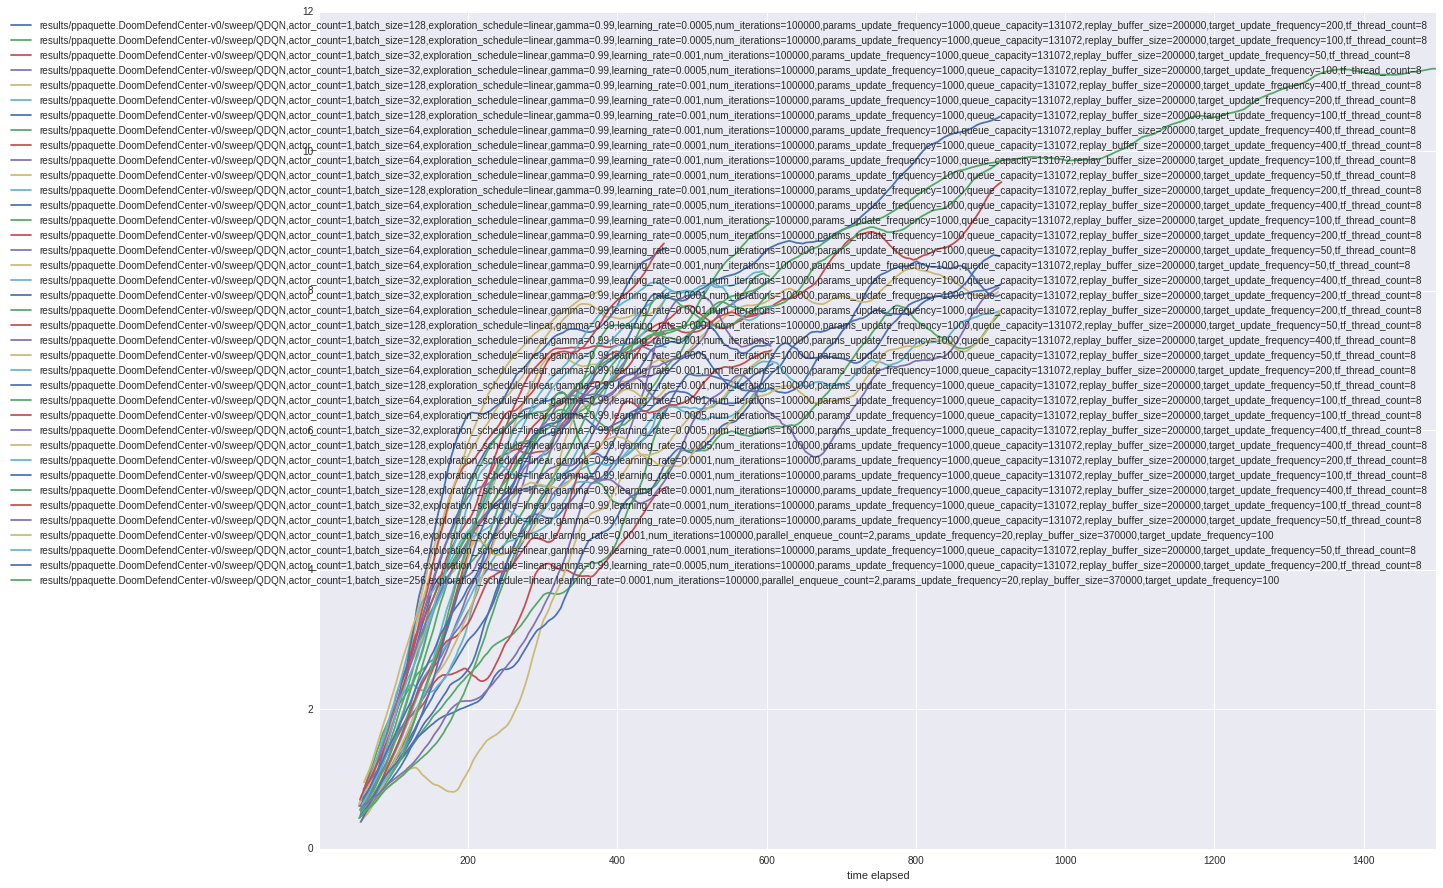

In [17]:
analyze_sweep(sweep_experiments, 'time elapsed', 'reward')

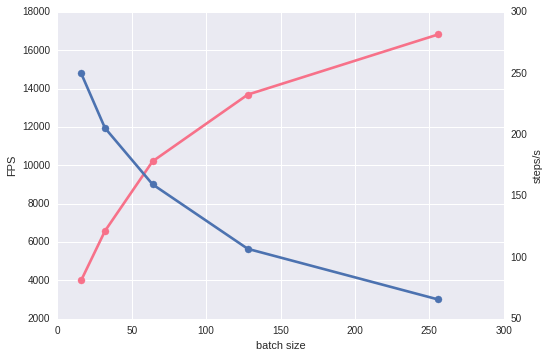

In [9]:
def plot_batch_size_vs_fps_vs_step_count(experiments):
    batch_sizes = []
    fps = []
    steps_per_second = []
    
    for experiment in experiments.values():
        batch_sizes.append(int(experiment['params']['batch_size']))
        fps.append(experiment['learner']['frames/s'].mean())
        steps_per_second.append(experiment['learner']['steps/s'].mean())
    
    df = pd.DataFrame({
        'batch size': batch_sizes,
        'FPS': fps,
        'steps/s': steps_per_second
    })
    with sns.color_palette("husl", 2):
        ax1 = sns.regplot(x='batch size', y='FPS', data=df, x_estimator=np.mean, lowess=True, truncate=True)
    ax2 = ax1.twinx()
    with sns.color_palette("husl", 1):
        sns.regplot(x='batch size', y='steps/s', data=df, x_estimator=np.mean, lowess=True, ax=ax2, truncate=True)
        ax2.grid(None)
    
plot_batch_size_vs_fps_vs_step_count(sweep_experiments)

In [38]:
def parallel_coordinates(frame, class_column, cols=None, ax=None, color=None,
                     use_columns=False, xticks=None, colormap=None,
                     **kwds):
    import matplotlib.pyplot as plt
    import matplotlib as mpl

    n = len(frame)
    class_col = frame[class_column]
    class_min = np.amin(class_col)
    class_max = np.amax(class_col)

    if cols is None:
        df = frame.drop(class_column, axis=1)
    else:
        df = frame[cols]

    used_legends = set([])

    ncols = len(df.columns)

    # determine values to use for xticks
    if use_columns is True:
        if not np.all(np.isreal(list(df.columns))):
            raise ValueError('Columns must be numeric to be used as xticks')
        x = df.columns
    elif xticks is not None:
        if not np.all(np.isreal(xticks)):
            raise ValueError('xticks specified must be numeric')
        elif len(xticks) != ncols:
            raise ValueError('Length of xticks must match number of columns')
        x = xticks
    else:
        x = range(ncols)

    fig = plt.figure()
    ax = plt.gca()

    Colorm = plt.get_cmap(colormap)

    for i in range(n):
        y = df.iloc[i].values
        kls = class_col.iat[i]
#         ax.plot(x, y, color=Colorm((kls - class_min)/(class_max-class_min)), **kwds)
        ax.plot(x, y, color=Colorm((kls - class_min)/(class_max-class_min)), alpha=(kls - class_min)/(class_max-class_min), **kwds)

    for i in x:
        ax.axvline(i, linewidth=1, color='black')

    ax.set_xticks(x)
    ax.set_xticklabels(df.columns)
    ax.set_xlim(x[0], x[-1])
    ax.set_ylim(0, 1.1)
    ax.legend(loc='upper right')
    ax.grid()

    bounds = np.linspace(class_min,class_max,20)
    cax,_ = mpl.colorbar.make_axes(ax)
    cb = mpl.colorbar.ColorbarBase(cax, cmap=Colorm, spacing='proportional', ticks=bounds, boundaries=bounds, format='%.2f')

    return fig

/home/acid/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


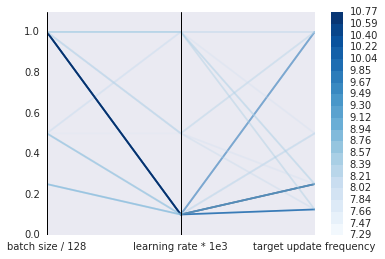

In [39]:
def plot_parallel_plot(experiments):
    batch_sizes = []
    learning_rates = []
    target_update_frequencies = []
    rewards = []
    
    for experiment in experiments.values():
        r = experiment['actor']['mean episode reward'].tail(10).max()
        if r > 8:
            params = experiment['params']
            batch_sizes.append(int(params['batch_size']) / 128.0)
            learning_rates.append(float(params['learning_rate']) / 1e-3)
            target_update_frequencies.append(int(params['target_update_frequency']) / 400.0)
            rewards.append(experiment['actor']['mean episode reward'].tail(10).mean())
    
    df = pd.DataFrame({
        'batch size / 128': batch_sizes,
        'learning rate * 1e3': learning_rates,
        'target update frequency': target_update_frequencies,
        'reward': rewards,
    })
    
    parallel_coordinates(df, 'reward', colormap='Blues')
#     plt.xscale('log')

plot_parallel_plot(sweep_experiments)

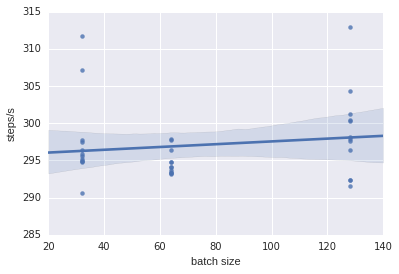

In [40]:
def plot_batch_size_vs_actor_steps(experiments):
    batch_sizes = []
    steps_per_second = []
    
    for experiment in experiments.values():
        params = experiment['params']
#         if int(params['target_update_frequency']) == 100:
#             print(params)
        batch_sizes.append(int(params['batch_size']))
        steps_per_second.append(experiment['actor']['steps/s'].mean())
    
    df = pd.DataFrame({
        'batch size': batch_sizes,
        'steps/s': steps_per_second
    })
    ax1 = sns.regplot(x='batch size', y='steps/s', data=df)
    
plot_batch_size_vs_actor_steps(sweep_experiments)

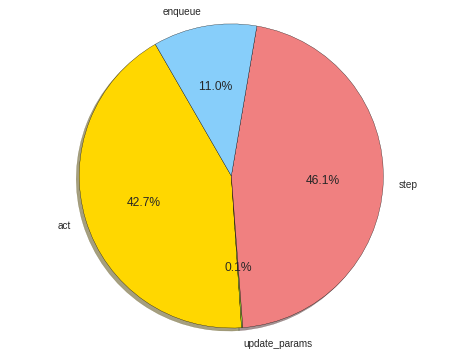

In [23]:
def plot_actor_shares(experiments):
    for experiment in experiments.values():
        params = experiment['params']
        if int(params['target_update_frequency']) != 100 or int(params['batch_size']) != 128 \
            or float(params['learning_rate']) != 1e-4:
            continue
            
        params_update_frequency = int(params['params_update_frequency'])
            
        act_time = experiment['actor']['act_time'].mean()
        queue_time = experiment['actor']['queue_time'].mean()
        step_time = experiment['actor']['step_time'].mean()
        update_params_time = experiment['actor']['update_params_time'].mean() / params_update_frequency
    
    sum_time = act_time + queue_time + step_time + update_params_time
    act_time /= sum_time
    queue_time /= sum_time
    step_time /= sum_time
    update_params_time /= sum_time
    
    # Plot
    colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
    plt.pie([act_time, update_params_time, step_time, queue_time],
            labels=['act', 'update_params', 'step', 'enqueue'],
            colors=colors, autopct='%1.1f%%', startangle=120, shadow=True)
    plt.axis('equal')
    plt.savefig('actor_pie.png', dpi=1200)
    
plot_actor_shares(sweep_experiments)

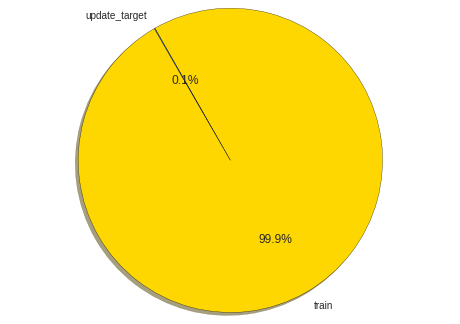

In [24]:
def plot_learner_shares(experiments):
    for experiment in experiments.values():
        params = experiment['params']
        if int(params['target_update_frequency']) != 100 or int(params['batch_size']) != 128 \
            or float(params['learning_rate']) != 1e-4:
            continue
            
        target_update_frequency = int(params['target_update_frequency'])
            
        train_time = experiment['learner']['train_time'].mean()
        update_target_time = experiment['learner']['update_target_time'].mean() / target_update_frequency
    
    sum_time = train_time + update_target_time
    train_time /= sum_time
    update_target_time /= sum_time
    
    # Plot
    colors = ['gold', 'lightskyblue']
    plt.pie([train_time, update_target_time],
            labels=['train', 'update_target'],
            colors=colors, autopct='%1.1f%%', startangle=120)
    plt.axis('equal')
    plt.savefig('learner_pie.png', dpi=600)
    
plot_learner_shares(sweep_experiments)

In [42]:
list(sweep_experiments.values())[0]['actor']

,% time spent exploring,act_share,act_time,episodes,global_step,mean episode reward,queue_share,queue_time,step,step_share,step_time,steps/s,time elapsed,update_params_share,update_params_time
0,100,39.882311,0.001536,10,0,0.1,10.050833,0.000387,560,49.955139,0.001924,279.319686,2.004868,NaN,NaN
1,99,28.994768,0.001977,20,19,0.3,8.037242,0.000548,1210,40.020791,0.002729,253.407331,4.774920,22.862618,0.003118
2,99,31.396580,0.001710,30,233,0.3,8.450911,0.000460,1809,40.986981,0.002233,268.863919,6.728310,19.079420,0.003118
3,98,27.753506,0.001642,40,445,0.3,7.523586,0.000445,2384,37.396123,0.002213,276.727780,8.614964,27.257711,0.003226
4,97,25.237092,0.001640,50,705,0.3,6.418674,0.000417,3096,30.157126,0.001959,282.336979,10.965619,38.129704,0.004954
5,96,26.186163,0.001606,60,947,0.3,6.627565,0.000407,3756,32.511580,0.001994,285.753611,13.144190,34.614720,0.004954
6,95,25.045798,0.001563,70,1176,0.3,6.474601,0.000404,4386,30.813731,0.001923,288.474301,15.204127,37.608239,0.004694
7,94,26.564634,0.001586,80,1390,0.2,6.711709,0.000401,4979,31.712729,0.001893,290.634747,17.131468,34.951746,0.004694
8,93,26.308200,0.001566,90,1649,0.3,6.505953,0.000387,5681,31.706034,0.001888,292.165216,19.444477,35.422214,0.004640
9,92,26.118631,0.001541,100,1874,0.3,6.435310,0.000380,6305,31.094909,0.001834,293.624504,21.473003,36.294867,0.004282


###### analyze_experiments(base_path, doom_exp, 'step', 'batch_max_td_error')

In [43]:
list(sweep_experiments.values())[0]['learner']

,batch_max_td_error,batch_min_td_error,frames/s,mean td_error,queue_size,step,steps/s,time elapsed,train_share,train_time,update_target_share,update_target_time
0,1.022359,-0.963548,5259.130082,-0.00057,122,300,41.086954,7.301603,NaN,NaN,NaN,NaN
1,0.933717,-0.845914,7675.496959,-0.00034,114,600,59.964820,10.005874,99.938780,0.008195,NaN,NaN
2,0.906241,-0.923831,9067.828374,0.00042,118,900,70.842409,12.704262,99.947315,0.008582,NaN,NaN
3,0.856800,-0.709074,9969.940287,0.00175,121,1200,77.890158,15.406322,98.303248,0.008625,1.649296,0.000434
4,0.956797,-0.985514,10605.363948,-0.00049,110,1500,82.854406,18.104058,98.711329,0.008685,1.233428,0.000434
5,0.074870,-0.773318,11075.729299,0.00060,119,1800,86.529135,20.802250,98.967286,0.008766,0.980227,0.000434
6,1.231804,-0.870972,11442.581677,-0.00089,114,2100,89.395169,23.491210,99.129086,0.008751,0.819600,0.000434
7,1.048576,-0.581860,11726.740761,0.00264,117,2400,91.615162,26.196550,98.576784,0.008740,1.375836,0.000427
8,1.090215,-0.836655,11954.360185,0.00021,112,2700,93.393439,28.909965,98.745367,0.008739,1.206125,0.000427
9,1.050767,-0.931127,12149.360996,0.00111,116,3000,94.916883,31.606612,98.873468,0.008714,1.076600,0.000427


Number of experiments: 9:


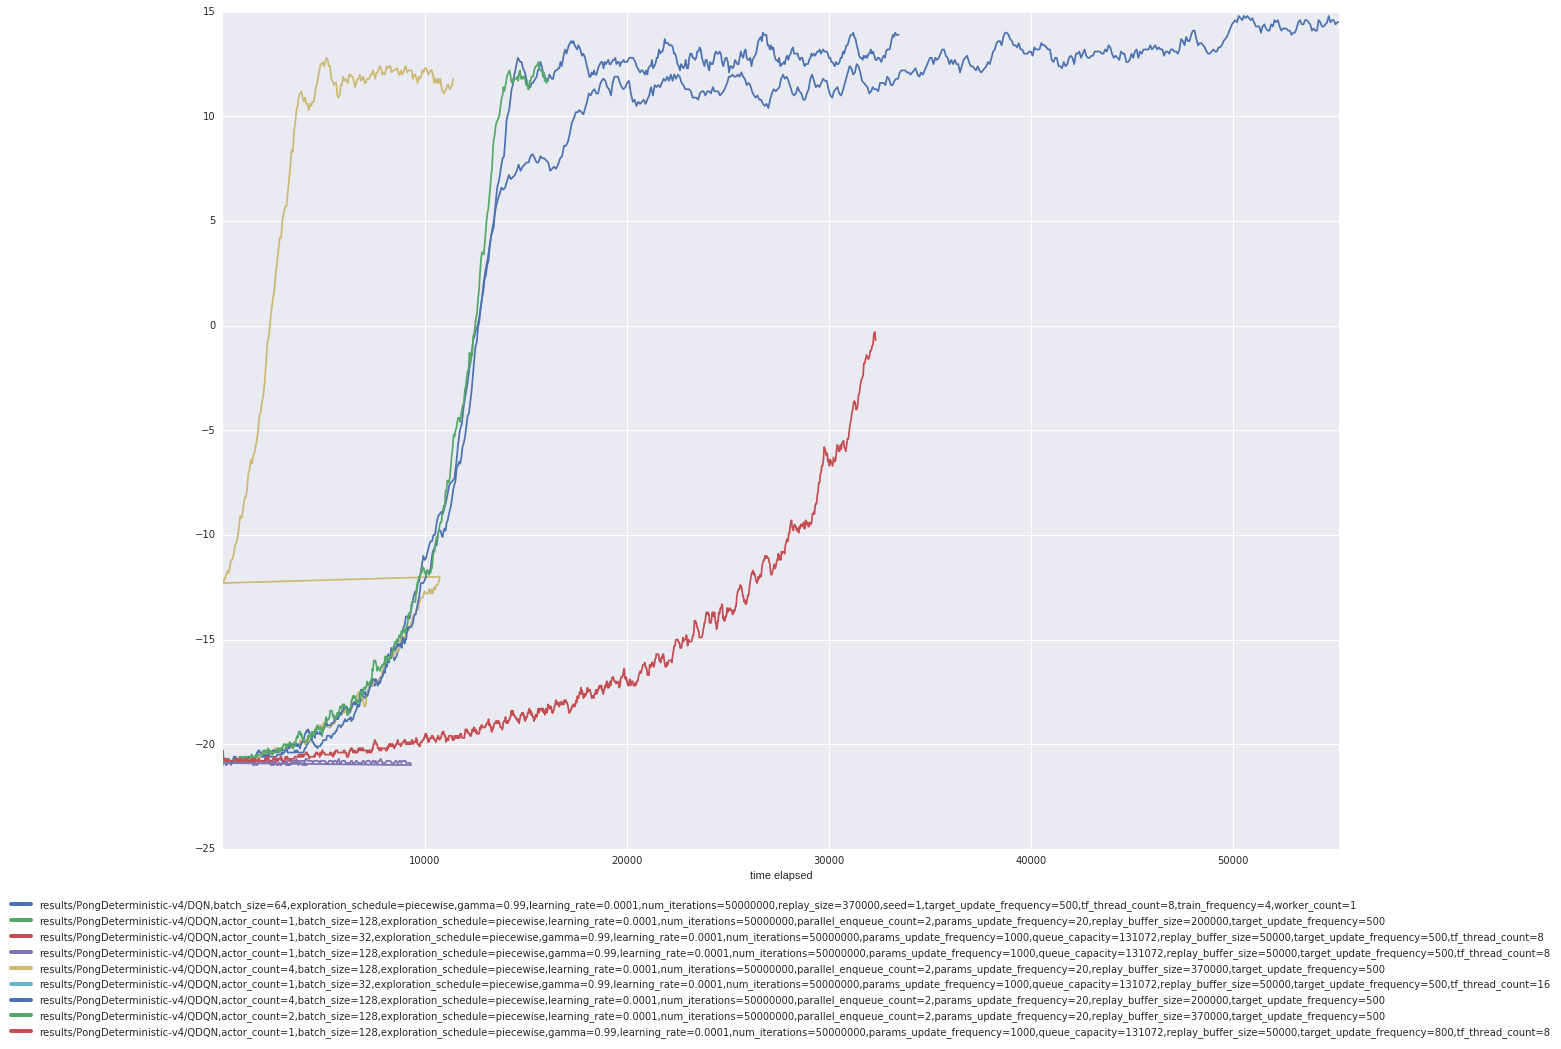

In [106]:
pong_experiments = read_experiments(lsdir('results/PongDeterministic-v4'))
print("Number of experiments: {}:".format(len(pong_experiments)))
analyze_experiments(pong_experiments, 'time elapsed', 'mean episode reward')

Number of experiments: 3:


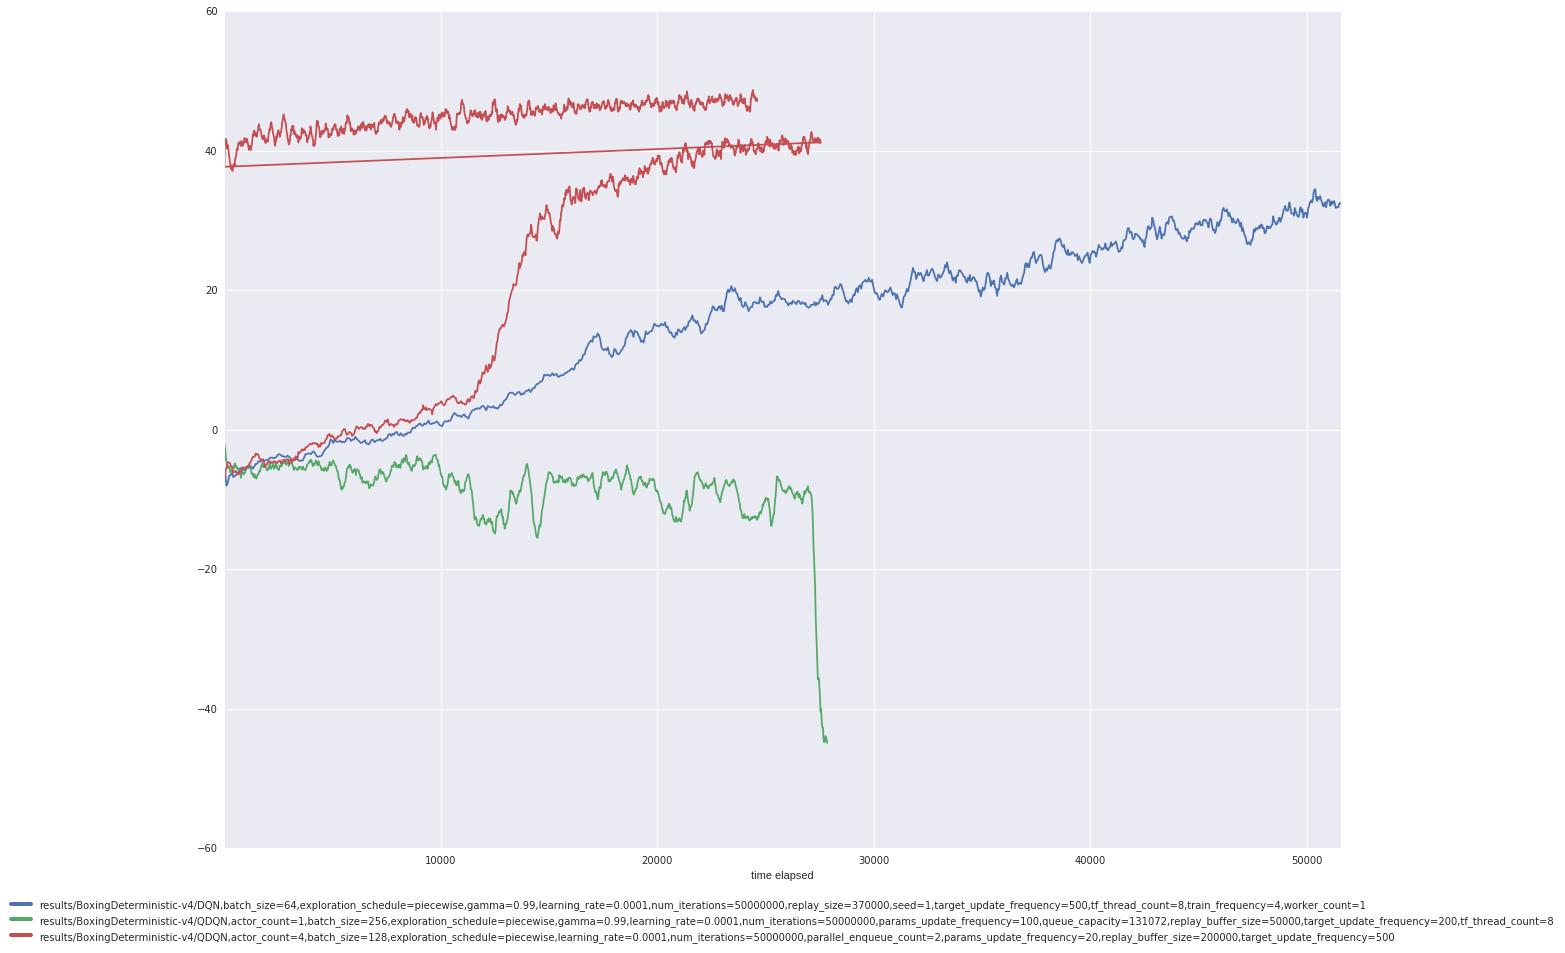

In [109]:
boxing_experiments = read_experiments(lsdir('results/BoxingDeterministic-v4'))
print("Number of experiments: {}:".format(len(boxing_experiments)))
analyze_experiments(boxing_experiments, 'time elapsed', 'mean episode reward')

In [107]:
final_pong_experiments = {
    'QDQN': pong_experiments['results/PongDeterministic-v4/QDQN,actor_count=4,batch_size=128,exploration_schedule=piecewise,learning_rate=0.0001,num_iterations=50000000,parallel_enqueue_count=2,params_update_frequency=20,replay_buffer_size=200000,target_update_frequency=500'],
    'DQN': read_experiments(['results/PongDeterministic-v4/DQN,batch_size=64,exploration_schedule=piecewise,gamma=0.99,learning_rate=0.0001,num_iterations=50000000,replay_size=370000,seed=1,target_update_frequency=500,tf_thread_count=8,train_frequency=4,worker_count=1']).popitem()[1]
}

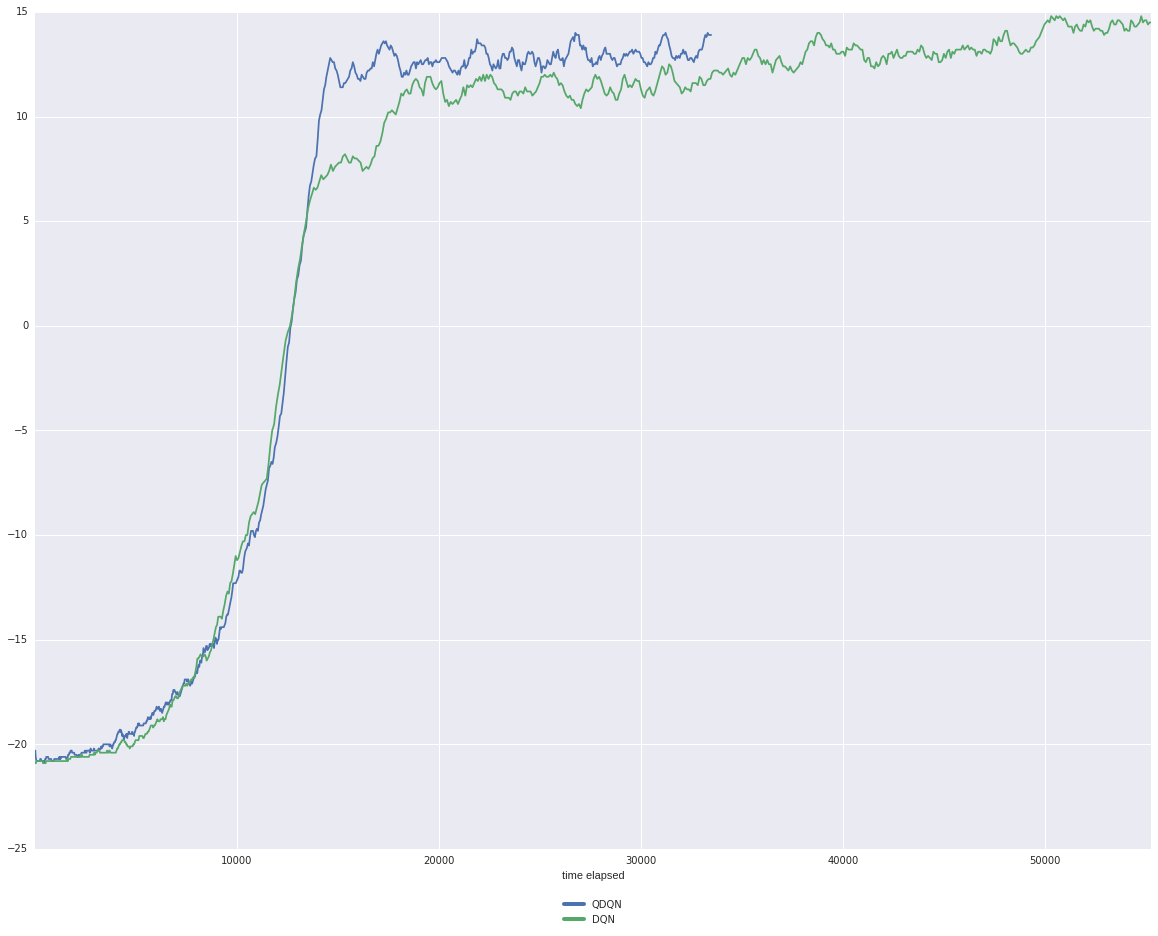

In [108]:
analyze_experiments(final_pong_experiments, 'time elapsed', 'mean episode reward')

/home/acid/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


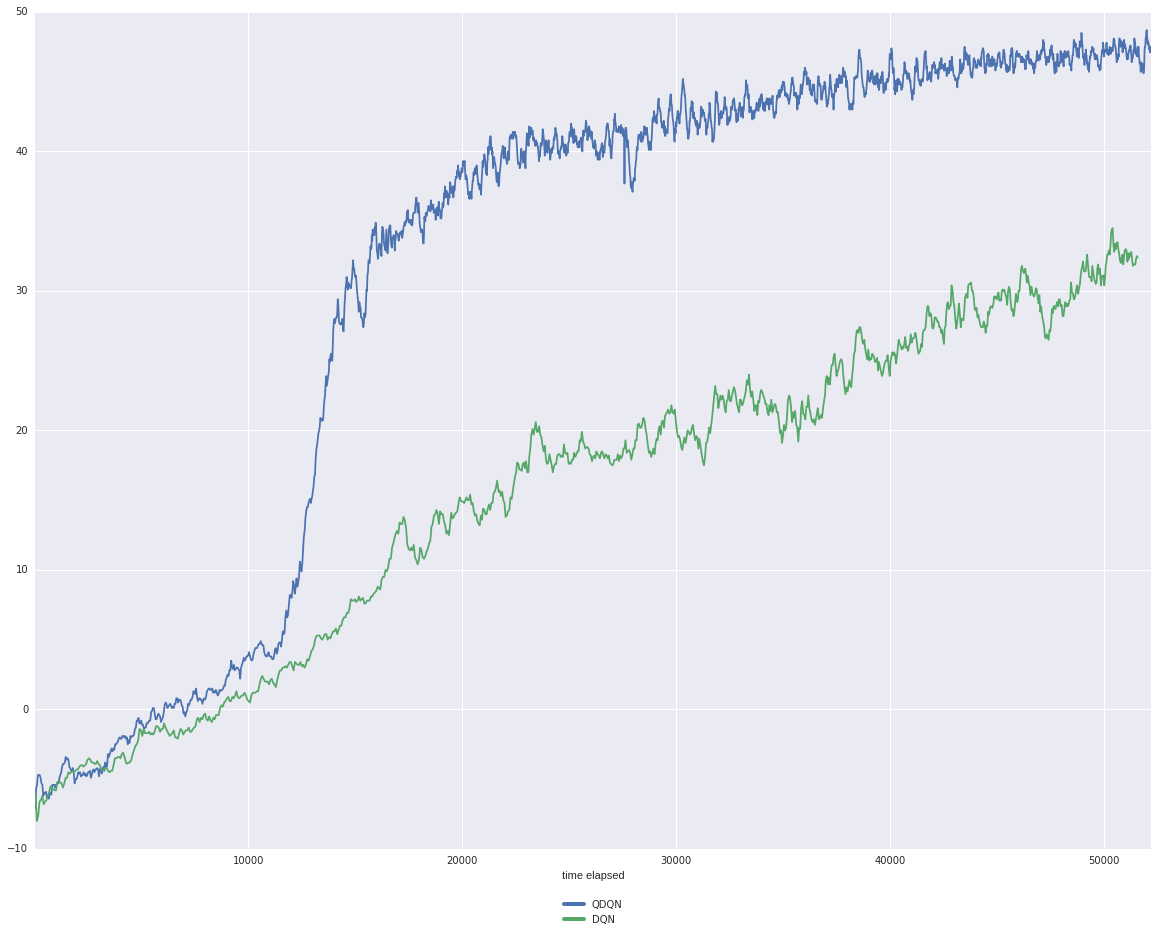

In [110]:
def fix_lag(experiment):
    experiment['actor'].iloc[1018:]['time elapsed'] += experiment['actor'].iloc[1017]['time elapsed'] 
    return experiment

final_boxing_experiments = {
    'QDQN': fix_lag(boxing_experiments['results/BoxingDeterministic-v4/QDQN,actor_count=4,batch_size=128,exploration_schedule=piecewise,learning_rate=0.0001,num_iterations=50000000,parallel_enqueue_count=2,params_update_frequency=20,replay_buffer_size=200000,target_update_frequency=500']),
    'DQN': read_experiments(['results/BoxingDeterministic-v4/DQN,batch_size=64,exploration_schedule=piecewise,gamma=0.99,learning_rate=0.0001,num_iterations=50000000,replay_size=370000,seed=1,target_update_frequency=500,tf_thread_count=8,train_frequency=4,worker_count=1']).popitem()[1]
}
analyze_experiments(final_boxing_experiments, 'time elapsed', 'mean episode reward')